## FDA Adverse Events Database Analysis

The Food and Drug Administration's (FDA) Center for Food Safety and Applied Nutrition (CFSAN) Adverse Event Reporting System (CAERS) is a database containing adverse events submitted about food, dietary supplements, and cosmetics. 

The README file for this data is located here: https://www.fda.gov/media/97035/download

Data source here: https://www.fda.gov/food/compliance-enforcement-food/cfsan-adverse-event-reporting-system-caers

Using this database, we will attempt to answer the following questions:

1. What is the trend of events over the 5 year period of the database 
for each category of product (food, cosmetics,supplements)?
2. Which food brands were associated with the most complaints?
3. How many events resulted in life threatening complications? What are the product descriptions (if available)?
4. Which cosmetic brands were associated with the most complaints?

It should be noted that patients who reported events used in this database may have had underlying conditions that contributed to any symptoms. We also make no conclusions concerning any product's contributions to any symptoms reported.

We will begin by cleaning the data before moving on to the above questions.

In [1]:
#Importing in libraries for analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#reading in dataset
caers = pd.read_csv('CAERSASCII 2014-20190331.csv')

In [2]:
#Exasmining the properties of the dataset
caers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80024 entries, 0 to 80023
Data columns (total 12 columns):
Report ID                 80024 non-null object
CAERS Created Date        80024 non-null object
Date of Event             30389 non-null object
Product Type              80024 non-null object
Product                   80014 non-null object
Product Code              74908 non-null object
Description               74908 non-null object
Patient Age               28811 non-null float64
Age Units                 28812 non-null object
Sex                       28230 non-null object
MedDRA Preferred Terms    78862 non-null object
Outcomes                  80024 non-null object
dtypes: float64(1), object(11)
memory usage: 7.3+ MB


Before we look at the data, first we should standardize the format of the column names.  It will make accessing the data in those columns much easier. These will be changed to all lowercase, and any spaces will be replaced with an underscore.

In [3]:
#Stripping any whitespace, making names lowercase, and replacing spaces with _
caers_cols = caers.columns
caers.columns = caers.columns.str.strip().str.lower().str.replace(' ','_')

#Changing the product column name, as that is the name of a python function:
caers.rename({'product':'product_name'}, axis=1, inplace=True)

Now let's examine a few rows from the dataset.

In [4]:
#Viewing the top rows
caers.head(2)

,report_id,caers_created_date,date_of_event,product_type,product_name,product_code,description,patient_age,age_units,sex,meddra_preferred_terms,outcomes
0,172940,1/1/14,NaN,SUSPECT,DANNON DANNON LITE &amp; FIT GREEK YOGURT CHERRY,9,Milk/Butter/Dried Milk Prod,NaN,NaN,NaN,NAUSEA,Other Outcome
1,172945,1/1/14,NaN,SUSPECT,SAVORITZ ORIGINAL BUTTERY ROUND CRACKERS,3,Bakery Prod/Dough/Mix/Icing,NaN,NaN,NaN,VOMITING,Other Outcome


From the properties of the dataset, we know the only column classified as numerical is patient_age. We suspect more columns can be classified as such, like report_id and product_code. Let's look at the properties of these columns to see if that is the case:

In [5]:
#Checking the number of numeric values in report_id column:
caers.report_id.str.isnumeric().sum()

55391

In [6]:
#Checking the number of nummeric values product_code column:
caers.product_code.str.isnumeric().sum()

74738

Neither the report_id column nor the product_code column can be classified as numeric. There are over 80,000 rows of data, and neither column has that many numeric values. Therefore both columns contain string values.

As a double check, we can print out the unique values of the product_code column. We would expect a finite number of product codes, so this should not be a long list. 

In [7]:
#Printing all unique values in the product_code column:
caers.product_code.unique()

array(['9', '3', '20', '23', '5', '16', '54', '31', '7', '25', '41', '39',
       '34', '40', '22', '2', '21', '28', '29', '53', '33', '24', '36',
       '27', '37', '26', '12', '45', '13', '40C', '41G', nan, '30', '38',
       '17', '32', '15', '14', '4', '35', '46', '18', '50', '40M', '40P',
       '40N', '40O'], dtype=object)

As suspected, there are product codes that include string values. 

The last column formatting we can do is change caers_created_date to a datetime object. This will make aggregating events by time easier. For the purposes of this project, we will use the caers_created_date column instead of the date_of_event column. This is due to the large amount of null values in date_of_event.

In [8]:
#Importing datetime library
from datetime import datetime as dt

#Converting CAERS created date column to datetime objects
caers.caers_created_date = pd.to_datetime(caers.caers_created_date)

Now that we've formatted the columns, let's check for duplicates in the dataset.

In [9]:
#Printing out a sample of the duplicates in the data
duplicates = caers.duplicated(keep=False)
caers.loc[duplicates,:].head(5)

,report_id,caers_created_date,date_of_event,product_type,product_name,product_code,description,patient_age,age_units,sex,meddra_preferred_terms,outcomes
98,173066,2014-01-09,NaN,CONCOMITANT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),94.0,year(s),F,"NIGHTMARE, INCREASED APPETITE, HEADACHE, CONFU...",Medically Important
99,173066,2014-01-09,NaN,CONCOMITANT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),94.0,year(s),F,"NIGHTMARE, INCREASED APPETITE, HEADACHE, CONFU...",Medically Important
100,173066,2014-01-09,NaN,CONCOMITANT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),94.0,year(s),F,"NIGHTMARE, INCREASED APPETITE, HEADACHE, CONFU...",Medically Important
101,173066,2014-01-09,NaN,CONCOMITANT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),94.0,year(s),F,"NIGHTMARE, INCREASED APPETITE, HEADACHE, CONFU...",Medically Important
279,173307,2014-01-22,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,65.0,year(s),M,"RASH, DERMATITIS CONTACT","Hospitalization, Patient Visited ER"


In this sample of data, all product names are EXEMPTION 4. EXEMPTION 4 is a redaction based on the Freedom of Information Act, to protect product trade secrets and/or commercial or finanncial information. For rows with this "product," we have no way of knowing what it actually is. This means these duplicates may not be duplicates at all.

Let's filter out the EXEMPTION 4's from the duplicates data to see if that affects the results. 

In [10]:
#Refiltering duplicates to exclude EXEMPTION 4's
caers.loc[duplicates & (caers.product_name!='EXEMPTION 4'),:].head(5)

,report_id,caers_created_date,date_of_event,product_type,product_name,product_code,description,patient_age,age_units,sex,meddra_preferred_terms,outcomes
947,174073,2014-02-19,1/10/14,SUSPECT,OSTEO BI-FLEX NUTRA JOINT DRINK MIX WITH GELATIN,54,Vit/Min/Prot/Unconv Diet(Human/Animal),74.0,year(s),F,"LARGE INTESTINAL HAEMORRHAGE, INFECTION, DIVER...","Hospitalization, Medically Important"
948,174073,2014-02-19,1/10/14,SUSPECT,OSTEO BI-FLEX NUTRA JOINT DRINK MIX WITH GELATIN,54,Vit/Min/Prot/Unconv Diet(Human/Animal),74.0,year(s),F,"LARGE INTESTINAL HAEMORRHAGE, INFECTION, DIVER...","Hospitalization, Medically Important"
1733,174892,2014-03-25,3/2/14,CONCOMITANT,OMEGA-3 (OMEGA-3 TRIGL YCERIDES),54,Vit/Min/Prot/Unconv Diet(Human/Animal),81.0,year(s),F,"MENTAL IMPAIRMENT, HEADACHE",Medically Important
1736,174892,2014-03-25,3/2/14,CONCOMITANT,OMEGA-3 (OMEGA-3 TRIGL YCERIDES),54,Vit/Min/Prot/Unconv Diet(Human/Animal),81.0,year(s),F,"MENTAL IMPAIRMENT, HEADACHE",Medically Important
1984,175155,2014-04-02,NaN,SUSPECT,PURITAN'S PRIDE BONE CARE COATED CAPLETS,54,Vit/Min/Prot/Unconv Diet(Human/Animal),68.0,year(s),M,"URINARY TRACT INFECTION, URINARY INCONTINENCE,...","Hospitalization, Patient Visited Healthcare Pr..."


These look to be true duplicates. Let's remove them from the dataframe, then see how many rows we have left:

In [11]:
#creating two different dataframes from caers, with and without EXEMPTION 4's
caers_not_EX4 = caers.loc[caers.product_name!='EXEMPTION 4',:]
caers_EX4 = caers.loc[caers.product_name=='EXEMPTION 4',:]

#dropping duplicates in the 'not exemption 4' dataframe
caers_not_EX4 = caers_not_EX4.drop_duplicates(keep='first')

#concatenating the two dataframes back together
caers = pd.concat([caers_not_EX4,caers_EX4], ignore_index=True)

#re-printing the column information
caers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79960 entries, 0 to 79959
Data columns (total 12 columns):
report_id                 79960 non-null object
caers_created_date        79960 non-null datetime64[ns]
date_of_event             30366 non-null object
product_type              79960 non-null object
product_name              79950 non-null object
product_code              74849 non-null object
description               74849 non-null object
patient_age               28790 non-null float64
age_units                 28791 non-null object
sex                       28209 non-null object
meddra_preferred_terms    78798 non-null object
outcomes                  79960 non-null object
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 7.3+ MB


Now that the known duplicates have been removed, there are a few inconsistencies we should take a closer look at. 

1. There are 10 rows where there is a product type, but no product name. 
2. There is one row where there is no age, but age units have been provided.
3. There are around 5,000 rows where the product code is missing.

We'll take a look at each, and attempt to correct when possible. Starting with number 1:

In [12]:
#Examining columns with product type, but no product name:
caers.loc[caers.product_name.isna(),:]

,report_id,caers_created_date,date_of_event,product_type,product_name,product_code,description,patient_age,age_units,sex,meddra_preferred_terms,outcomes
40653,2017-CFS-002558,2017-12-13,12/11/17,SUSPECT,NaN,NaN,NaN,NaN,NaN,NaN,"Vomiting, Retching, Malaise, Gastroenteritis v...",Medically Important
43337,2018-CFS-003956,2018-03-08,12/11/17,SUSPECT,NaN,NaN,NaN,NaN,NaN,NaN,"Vomiting, Retching, Flatulence, Feeling hot, D...",Other Seriousness
43941,2018-CFS-005210,2018-03-29,NaN,SUSPECT,NaN,NaN,NaN,NaN,NaN,NaN,"Gastrointestinal obstruction, Flatulence, Diar...","Hospitalization, Medically Important"
44005,2018-CFS-005277,2018-03-30,NaN,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,"Weight decreased, Decreased appetite",Medically Important
44057,2018-CFS-005326,2018-04-02,3/16/18,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,Diarrhoea,Medically Important
44061,2018-CFS-005327,2018-04-02,3/28/18,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,"Palpitations, Flushing",Medically Important
49814,2018-CFS-012850,2018-10-24,9/30/18,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,Convulsion,Medically Important
50827,2018-CFS-014689,2018-12-17,NaN,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,"Ovarian cancer, Metastasis, Haemorrhagic tumou...",Medically Important
52924,2019-CFS-002822,2019-03-19,12/10/18,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,Skin discolouration,Disability
52973,2019-CFS-002889,2019-03-20,3/14/19,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,"Vomiting, Nausea, Gastroenteritis, Diarrhoea, ...","Hospitalization, Patient Visited ER"


We're going to drop these from the dataset, as there is no product information available.

In [13]:
#Dropping the columns:
caers = caers.loc[caers.product_name.notna(),:]

Next we'll look at the row that has no age, but has age units:

In [14]:
#Filtering out column with age unit, but no age:
caers.loc[(caers.patient_age.isna()) & (caers.age_units.notna()),:]

,report_id,caers_created_date,date_of_event,product_type,product_name,product_code,description,patient_age,age_units,sex,meddra_preferred_terms,outcomes
40299,2017-CFS-002182,2017-11-30,NaN,SUSPECT,VIVISCAL PROFESSIONAL,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,year(s),F,"Menstruation irregular, Acne cystic",Other Seriousness


We can leave this row in the dataset, as most rows don't have an age. This row also contains relevant product information. 

However, based on this data slice, we should further investigate the age_units column. This data shows year(s), but are there any other units? If so, we should normalize all ages to years.

In [15]:
#Retrieving counts of data in age_units column:
caers.age_units.value_counts()

year(s)     28358
month(s)      402
day(s)         31
Name: age_units, dtype: int64

In [16]:
#Grabbing a row of test data before normalization:
test_age = caers.loc[caers.age_units=='month(s)',:].head(1)
test_age

,report_id,caers_created_date,date_of_event,product_type,product_name,product_code,description,patient_age,age_units,sex,meddra_preferred_terms,outcomes
66,173021,2014-01-08,NaN,SUSPECT,SIMILAC ADVANCED PLUS OR COMPLETE NUTRITION PO...,40,Baby Food Products,16.0,month(s),F,VOMITING,Other Outcome


In [17]:
#creating a function to normalize the ages:
def normalize_age(age,units):
    if units == 'day(s)':
        age = age/365
        return age
    elif units == 'month(s)':
        age = age/12
        return age
    else:
        return age

#applying the function to the patient_age and age_units column
caers.patient_age = caers.loc[:,['patient_age','age_units']].apply(lambda x: normalize_age(x['patient_age'],x['age_units']), axis=1)

#replacing all values in age_units column to year(s)
caers.age_units = caers.age_units.replace({'month(s)':'year(s)','day(s)':'year(s)'})

#checking that the function worked
print(caers.age_units.value_counts())
caers.iloc[test_age.index,:]

year(s)    28791
Name: age_units, dtype: int64


,report_id,caers_created_date,date_of_event,product_type,product_name,product_code,description,patient_age,age_units,sex,meddra_preferred_terms,outcomes
66,173021,2014-01-08,NaN,SUSPECT,SIMILAC ADVANCED PLUS OR COMPLETE NUTRITION PO...,40,Baby Food Products,1.333333,year(s),F,VOMITING,Other Outcome


We still have 5,000 rows of missing data for product_code. Is there a way to fill in any of this? 

In [18]:
#Returning top product names that have missing product codes (excluding EXEMPTION 4's)
names = caers.loc[(caers.product_code.isna()) & (caers.product_name !='EXEMPTION 4'),:]['product_name'].value_counts().head(20)
names

Vitamin D       146
VITAMIN D        87
Multivitamin     86
Vitamin C        77
Calcium          77
Fish Oil         59
Magnesium        57
Biotin           57
MULTIVITAMIN     54
Vitamin D3       53
VITAMIN C        49
CALCIUM          47
FISH OIL         46
B12              43
BIOTIN           33
MAGNESIUM        31
VITAMIN D3       31
Vitamin E        29
multivitamin     28
Melatonin        28
Name: product_name, dtype: int64

Interestingly, these are all vitamins or supplements! This corresponds to product code 54, or "Vit/Min/Prot/Unconv Diet(Human/Animal)" via the description. We can fill these in. We'll do this by dividing this process into two steps. One, we'll search for product names that contain the string "vitamin," and address them. Second, we will re-filter for product names containing "supplement."

In [19]:
#Step 1

#Changing all product names to uppercase for standardization
caers.product_name = caers.product_name.str.upper()

#Looking for the string 'vitamin' in the product_name column
mask = (caers.product_code.isna()) & (caers.product_name !='EXEMPTION 4') & (caers.product_name.str.contains('VITAMIN'))
names = caers.loc[mask,:]['product_name']

#converting the names we're searching for to a list
names = names.tolist()

#checking for a match between all product names in the dataframe and the names list
match = caers.product_name.isin(names) 

#assigning all matches to the product code 54, and updating the description:
caers.loc[match,'product_code'] = 54
caers.loc[match,'description'] ='Vit/Min/Prot/Unconv Diet(Human/Animal)'

#rechecking the product_code column
caers.product_code.describe()

count     76413
unique       47
top          53
freq      31557
Name: product_code, dtype: object

In [20]:
#Applying Step 1 again

#Re-filtering the data frame for na values in the product_code column
mask = (caers.product_code.isna()) & (caers.product_name !='EXEMPTION 4')
names2 = caers.loc[mask,:]['product_name']

#taking the top recurring product names and adding them to a list
names2 = names2.value_counts().head(30).index.tolist()
print(names2)

['FISH OIL', 'CALCIUM', 'MAGNESIUM', 'BIOTIN', 'B12', 'MELATONIN', 'PROBIOTIC', 'IRON', 'PROBIOTICS', 'FOLIC ACID', 'TURMERIC', 'POTASSIUM', 'COQ10', 'ZINC', 'OTHER MEDICATIONS', 'D3', 'CENTRUM SILVER', 'B-12', 'B COMPLEX', 'OMEGA 3', 'KRILL OIL', 'LUTEIN', 'GARLIC', 'NIACIN', 'CRANBERRY', 'FLAXSEED OIL', 'GLUCOSAMINE', 'MILK THISTLE', 'OMEGA-3', 'BLOOD PRESSURE MEDICATIONS']


In [21]:
#removing product that are not or may not be vitamins from this list:
names_to_remove = (['PROBIOTIC','PROBIOTICS','TURMERIC','OTHER MEDICATIONS','GARLIC','CRANBERRY',
             'FLAXSEED OIL','BLOOD PRESSURE MEDICATIONS', 'RED YEAST RICE'])
names2 = [n for n in names2 if n not in names_to_remove]

#checking for a match between all product names in the dataframe and this new names list
match2 = caers.product_name.isin(names2) 

#assigning all matches to the product code 54, and updating the description:
caers.loc[match2,'product_code'] = 54
caers.loc[match2,'description'] ='Vit/Min/Prot/Unconv Diet(Human/Animal)'

#rechecking the product_code column
caers.product_code.describe()

count     77378
unique       47
top          53
freq      31557
Name: product_code, dtype: object

In [22]:
#Applying Step 1 again

#Re-filtering the data frame for na values in the product_code column
mask = (caers.product_code.isna()) & (caers.product_name !='EXEMPTION 4')
names2 = caers.loc[mask,:]['product_name']

print(names2.head(30))

679                                      PREVAGEN
35226                          LIQUID GLUCOSAMINE
35246                             HYALURONIC ACID
35247                                 RESVERATROL
35248                                   MOVE FREE
35249                                    SELENIUM
35364                          UNKNOWN SUPPLEMENT
35444                             HERSHEY'S COCOA
35445                        CONTINENT 8 SOY MILK
35446                                BLACK PEPPER
35511                                 VICON FORTE
35515                                  POTASSIUM(
35519    NUTRITIONAL SUPPLEMENT (OTHER NUTRIENTS)
35526      ACIDOPHILUS(LACTOBACILLUS ACIDOPHILUS)
35600              OMEGA 3 (TOCOPHEROL, FISH OIL)
35602                   IRON (DIETARY SUPPLEMENT)
35622                         SUPER BETA PROSTATE
35630                          CALCITRIOL (OSCAL)
35654                                      COQ-10
35656                                SAW PALMETTO


We've now attempted to apply the first step 3 times. On this last run, our list of product names contained many products that were not vitamins. Based on this, we can move on to step 2 in the process. For this, we will look for the word "supplement," and fill in product code 54 for these rows.

In [23]:
#Looking for the string 'supplement in the product_name column
mask = (caers.product_code.isna()) & (caers.product_name !='EXEMPTION 4') & (caers.product_name.str.contains('SUPPLEMENT'))
names3 = caers.loc[mask,:]['product_name']

#converting the names we're searching for to a list
names3 = names3.tolist()

#checking for a match between all product names in the dataframe and the names list
match3 = caers.product_name.isin(names3) 

#assigning all matches to the product code 54, and updating the description:
caers.loc[match3,'product_code'] = 54
caers.loc[match3,'description'] ='Vit/Min/Prot/Unconv Diet(Human/Animal)'

#One last look at the dataframe
caers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79950 entries, 0 to 79959
Data columns (total 12 columns):
report_id                 79950 non-null object
caers_created_date        79950 non-null datetime64[ns]
date_of_event             30359 non-null object
product_type              79950 non-null object
product_name              79950 non-null object
product_code              77474 non-null object
description               77474 non-null object
patient_age               28790 non-null float64
age_units                 28791 non-null object
sex                       28209 non-null object
meddra_preferred_terms    78788 non-null object
outcomes                  79950 non-null object
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 7.9+ MB


By filling in the correct product codes/descriptions for vitamins and supplements, we've decreased the number of null values. There were originally 74,908 non-null values in these columns, and we've increased this to 77,474.

This concludes the data cleaning! Let's move on to answering the questions first posed at the start of the project. We'll start with the first question: What is the trend of events over the 5 year period of the database for each category of product (food, cosmetics,etc)? This covers the years 2014-2019.

In [24]:
#Printing total number of events by product description
caers.description.value_counts()

 Cosmetics                                       31557
 Vit/Min/Prot/Unconv Diet(Human/Animal)          27020
Vit/Min/Prot/Unconv Diet(Human/Animal)            7529
 Vegetables/Vegetable Products                    1435
 Fruit/Fruit Prod                                  821
 Bakery Prod/Dough/Mix/Icing                       820
 Soft Drink/Water                                  812
 Nuts/Edible Seed                                  753
 Cereal Prep/Breakfast Food                        751
 Dietary Conventional Foods/Meal Replacements      748
 Fishery/Seafood Prod                              600
 Mult Food Dinner/Grav/Sauce/Special               515
 Milk/Butter/Dried Milk Prod                       438
 Snack Food Item                                   406
 Ice Cream Prod                                    367
 Baby Food Products                                337
 Coffee/Tea                                        307
 Choc/Cocoa Prod                                   216
 Food Addi

There is whitespace around the product descriptions in this column. Let's remove this before moving on:

In [25]:
#Removing whitespace around product descriptions
caers.description = caers.description.str.strip()

#Re-printing the number of events by product description
caers.description.value_counts()

Vit/Min/Prot/Unconv Diet(Human/Animal)          34549
Cosmetics                                       31557
Vegetables/Vegetable Products                    1435
Fruit/Fruit Prod                                  821
Bakery Prod/Dough/Mix/Icing                       820
Soft Drink/Water                                  812
Nuts/Edible Seed                                  753
Cereal Prep/Breakfast Food                        751
Dietary Conventional Foods/Meal Replacements      748
Fishery/Seafood Prod                              600
Mult Food Dinner/Grav/Sauce/Special               515
Milk/Butter/Dried Milk Prod                       438
Snack Food Item                                   406
Ice Cream Prod                                    367
Baby Food Products                                337
Coffee/Tea                                        307
Choc/Cocoa Prod                                   216
Food Additives (Human Use)                        215
Whole Grain/Milled Grain Pro

Based on the product descriptions above, it makes sense to divide this data up into 3 categories: cosmetics, food, and vitamins/minerals/supplements. We can add a column to the dataframe for this:

In [26]:
#Adding a new column to the dataframe to properly categorize each event as either Supplements, Cosmetics, or Food
caers.loc[caers.description=='Vit/Min/Prot/Unconv Diet(Human/Animal)','product_category']='Supplements'
caers.loc[caers.description=='Cosmetics','product_category']='Cosmetics'
caers.loc[~(caers.description.isin(['Vit/Min/Prot/Unconv Diet(Human/Animal)','Cosmetics'])),'product_category']='Food'

Next we'll create a pivot table and graph the number of events per month, per product category:

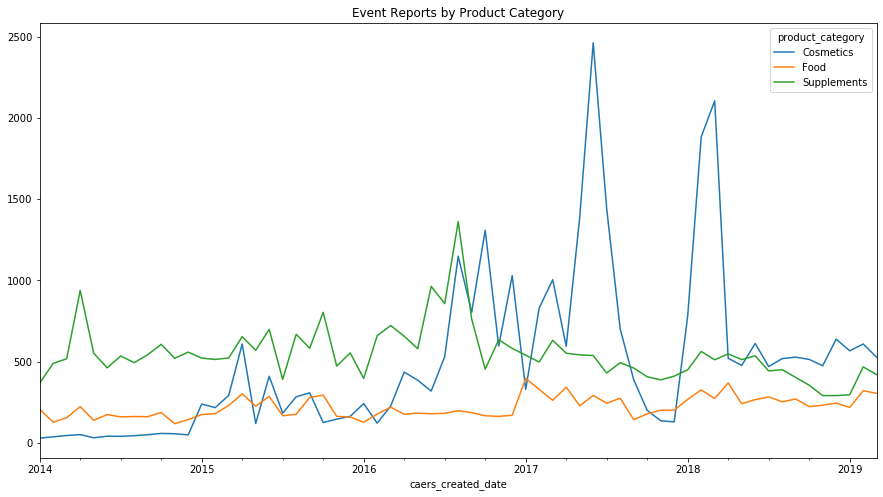

In [27]:
#create pivot table of the number of incidents per month
num_reports = pd.pivot_table(columns='product_category',index=caers.caers_created_date.dt.to_period('M'),values='report_id',data=caers,aggfunc='count')

#Plot the pivot table
num_reports.plot(figsize=(15,8))
plt.title('Event Reports by Product Category')
plt.show()

At the beginning of 2014, supplements had the most complaints, followed by food, and then cosmetics. By the beginning of 2019, cosmetics had the most complaints with food having the least. Cosmetics first overtook both food and supplements for number of complaints in 2016. Cosmetics had the most dramatic rise in complaints in the middle of 2017, and then again at the beginning of 2018. In both of these time periods, cosmetics far outpaced the other two categories. Whereas food and supplements both had 500 or less complaints, cosmetics reached above 2000. 

Now on to question 2: which food brands received the most complaints? Since there are many product descriptions in this dataset, let's find the top brand associated with each. We'll also exclude EXEMPTION 4's from consideration, as this gives us no product information.

In [28]:
#filtering dataset by Food category and excluding EXEMPTION 4's. Grouping by product description
desc_grp = caers.loc[(caers.product_category=='Food') & (caers.product_name !='EXEMPTION 4'),:].groupby('description')

#finding the brand with most complaints per product description
most_complaints = desc_grp['product_name'].apply(lambda x:x.value_counts(normalize=True).head(1))*100

#creating a dataframe for this data and renaming the columns
most_complaints = most_complaints.to_frame().reset_index()
most_complaints.columns = ['description','product_name','% of Events']

#getting the total number of complaints per product description
total_complaints = caers.groupby('description').count().reset_index().loc[:,('description','report_id')]
most_complaints = most_complaints.merge(total_complaints,on='description')

#renaming the last column
most_complaints.rename(columns={'report_id':'Total Events'},inplace=True)

#printing the dataframe
most_complaints

,description,product_name,% of Events,Total Events
0,Alcoholic Beverage,GOYA MALTA GOYA MALT BEVERAGE,14.285714,7
1,Baby Food Products,ENFAMIL GENTLEASE,2.821317,337
2,Bakery Prod/Dough/Mix/Icing,NABISCO HONEY MAID GRAHAM CRACKERS,0.889454,820
3,Beverage Bases/Conc/Nectar,NOT ESTABLISHED EXPERMINATAL ENERGY DRINK,4.081633,49
4,"C Formula, Form Unspecified",NEOCATE INFANT,22.222222,9
5,Candy W/O Choc/Special/Chew Gum,SKITTLES ORIGINAL SKITTLES,2.777778,181
6,Cereal Prep/Breakfast Food,GLUTEN FREE CHEERIOS,8.548168,751
7,Cheese/Cheese Prod,CABOT'S PREMIUM NATURALL AGED EXTRA SHARP CHED...,1.379310,154
8,Choc/Cocoa Prod,NESTLE RICH MILK CHOCOLATE FLAVOR MIX (POWDER),1.895735,216
9,Coffee/Tea,GREEN TEA,2.675585,307


Now for question 3: how many incidents resulted in life threatening complications? First let's get a sense of the outcomes coded in the dataset.

In [29]:
#printing out all unique outcomes in the dataset
caers.outcomes.unique()

array(['Other Outcome',
       'Hospitalization, Patient Visited Healthcare Provider',
       'Medically Important', 'Hospitalization',
       'Patient Visited Healthcare Provider, Medically Important',
       'Disability, Patient Visited Healthcare Provider',
       'Life Threatening, Patient Visited Healthcare Provider, Patient Visited ER',
       'Medically Important, Patient Visited ER', 'Patient Visited ER',
       'Life Threatening, Hospitalization, Patient Visited Healthcare Provider, Patient Visited ER',
       'Patient Visited Healthcare Provider',
       'Disability, Medically Important, Patient Visited ER',
       'Life Threatening, Patient Visited ER',
       'Life Threatening, Hospitalization, Patient Visited Healthcare Provider, Patient Visited ER, Required Intervention',
       'Patient Visited ER, Required Intervention',
       'Life Threatening, Hospitalization, Disability, Medically Important',
       'Patient Visited Healthcare Provider, Medically Important, Patient 

There are many combinations of outcomes reported, but there are 2 key phrases that stick out. These are "Life Threatening" and "Death." We will filter the dataset on these, and see what product names are available. It is likely that many of these are coded EXEMPTION 4's.

In [30]:
#filtering the dataframe by outcomes containing the phrase 'Life Threatening' or 'Death'
mask = ((caers.outcomes.str.contains('Life Threatening'))|(caers.outcomes.str.contains('Death')))
outcomes = caers.loc[mask,:]

#printing number of outcomes
print('Number of Life Threatening/Death reports:',outcomes.shape[0])
print('Percentage of Life Threatening/Death reports out of all reported: {:.2%}'.format(outcomes.shape[0]/caers.shape[0]))

Number of Life Threatening/Death reports: 10663
Percentage of Life Threatening/Death reports out of all reported: 13.34%


Thankfully the amount of reported incidents resulting in life threatening complications is fairly low, around 13.33%. How many of these are coded as EXEMPTION 4's?

In [31]:
caers.loc[mask & (caers.product_name == 'EXEMPTION 4'),:].shape[0]

7026

Unsurprisingly, the vast majority of incidents coded as Death or Life Threatening don't have product names available. Given that, what is left? We'll look at the product names associated with the most events.

In [32]:
#printing out product names associated with life threatening/death outcomes, excluding EXEMPTION 4's
caers.loc[mask & (caers.product_name!='EXEMPTION 4'),'product_name'].value_counts().head(10)

KRATOM                 123
MULTIVITAMIN            46
VITAMIN D               43
FISH OIL                32
CALCIUM                 25
VITAMIN D3              23
VITAMIN C               23
SUPER BETA PROSTATE     20
MAGNESIUM               18
VITAMIN E               15
Name: product_name, dtype: int64

Most of these products are vitamins or supplements. However, no particular one accounts for a majority of reported issues.

Let's answer the last question, which takes a look at cosmetics. Which products resulted in the most reported incidents?

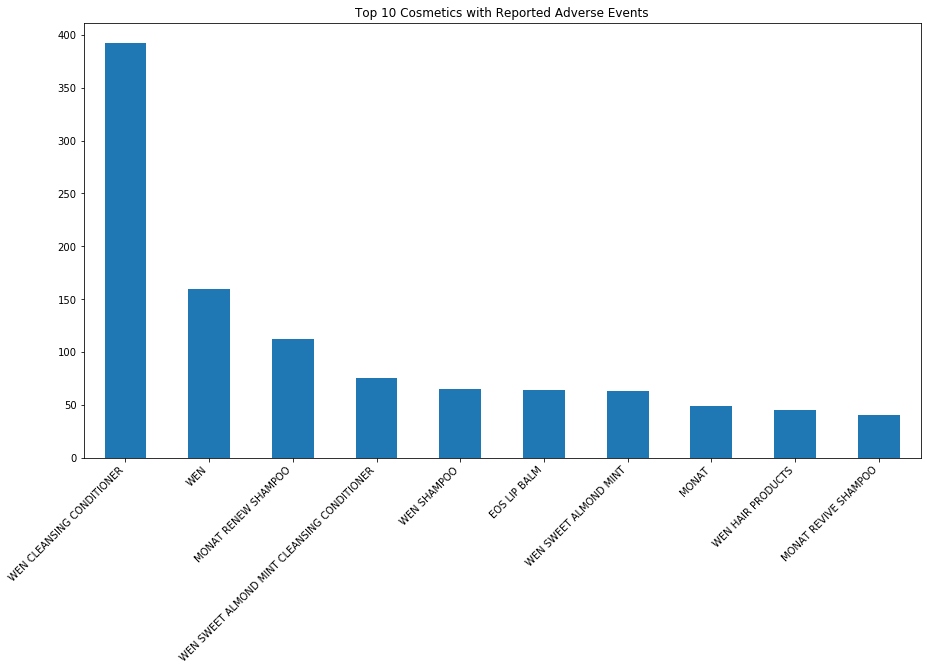

In [33]:
#filtering by cosmetics not coded as EXEMPTION 4's
cosmetics = caers.loc[(caers.product_category=='Cosmetics') & (caers.product_name!='EXEMPTION 4'),:]

#printing bar graph of top 10 products
cosmetics.product_name.value_counts().head(10).plot(kind='bar',figsize=(15,8))
plt.xticks(rotation=45,horizontalalignment='right')
plt.title('Top 10 Cosmetics with Reported Adverse Events')
plt.show()

The most commonly reported cosmetics incidents were generally related to the Wen and Monat haircare product lines. Wen Cleansing Conditioner had the most reported incidents of any cosmetics brand product, at almost 400. Let's dig deeper on this particular product to see the trend of complaints over time, and what kind of complaints were most common.

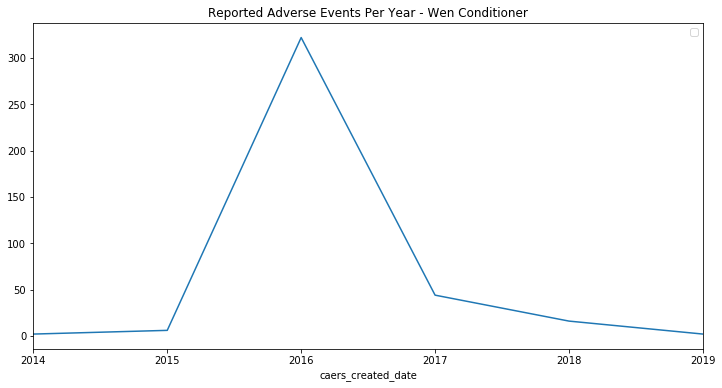

In [34]:
#filtering dataframe for the top product
wen_cc = caers.loc[caers.product_name=='WEN CLEANSING CONDITIONER',:]

#create pivot table of the number of incidents per year
wen_reports = pd.pivot_table(columns='product_category',index=caers.caers_created_date.dt.to_period('Y'),values='report_id',data=wen_cc,aggfunc='count')

#Graph the pivot
wen_reports.plot(figsize=(12,6))
plt.title('Reported Adverse Events Per Year - Wen Conditioner')
plt.legend([])
plt.show()

Based on the graph above, almost all the reported incidents happened in 2016, and then dropped off. To conclude our look into this product, let's find out what the most common reported symptoms were by patients.

In [35]:
#stripping white space and separating symptoms out by the comma delimiter
symptoms = wen_cc['meddra_preferred_terms'].str.upper().str.strip().str.split(', ')

#creating a dictionary to hold the symptom counts
dict = {}

#counting the symptoms, storing each symptom as a dictionary key
for row in symptoms:
    for word in row:
        if word not in dict:
            dict[word]=1
        else:
            dict[word]+=1

#sorting the dictionary by count of symptom occurence
sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda x: x[1], reverse=True)}
sorted_dict

{'ALOPECIA': 496,
 'PRURITUS': 74,
 'TRICHORRHEXIS': 46,
 'HAIR TEXTURE ABNORMAL': 31,
 'RASH': 29,
 'SKIN IRRITATION': 19,
 'ERYTHEMA': 17,
 'SKIN EXFOLIATION': 14,
 'HAIR DISORDER': 13,
 'DRY SKIN': 13,
 'HAIR GROWTH ABNORMAL': 12,
 'BURNING SENSATION': 10,
 'WOUND': 8,
 'STRESS': 8,
 'SWELLING': 8,
 'SEBORRHOEA': 7,
 'DANDRUFF': 7,
 'SCAB': 7,
 'PAIN OF SKIN': 7,
 'ACNE': 6,
 'HYPERSENSITIVITY': 6,
 'HAEMORRHAGE': 5,
 'PARAESTHESIA': 5,
 'PAIN': 5,
 'RASH PRURITIC': 4,
 'SKIN SENSITISATION': 4,
 'EMOTIONAL DISTRESS': 4,
 'HYPOTRICHOSIS': 3,
 'LOCAL SWELLING': 3,
 'SKIN DISORDER': 3,
 'INFLAMMATION': 3,
 'ECZEMA': 3,
 'SCAR': 3,
 'SELF ESTEEM DECREASED': 3,
 'PSORIASIS': 2,
 'ALOPECIA AREATA': 2,
 'BIOPSY SKIN ABNORMAL': 2,
 'TENDERNESS': 2,
 'URTICARIA': 2,
 'CHEMICAL INJURY': 2,
 'DISCOMFORT': 2,
 'RASH GENERALISED': 2,
 'SKIN INJURY': 2,
 'SKIN ULCER': 2,
 'HAIR COLOUR CHANGES': 1,
 'WOUND DRAINAGE': 1,
 'OCULAR HYPERAEMIA': 1,
 'EYE SWELLING': 1,
 'HYPOTHYROIDISM': 1,
 'AGITATION

From the information above, the top reported symptom for this conditioner was alopecia (hair loss), followed by pruritis (itching) and trichorrexhis (formation of nodes in hair shafts causing breakage). 

This concludes our analysis of the FDA Adverse Event Reporting System database. First we looked at the overall trend of complaints over time for food, cosmetics, and supplements. We noticed that cosmetics has gone from having the least number of events to the most, surpassing both food and supplements as of 2016.

Next we determined the food brands with the most complaints. We provided the top food brand for each category of food, and saw that no one brand accounted for the majority of these events.

Then we investigated which events had complications which were life threatening or resulted in death. Most of these product names were redacted, however without redactions we noticed that supplements were the most associated with these outcomes. 

Last, we looked at cosmetics and which brands had the most events reported. Most of the top 10 products were either shampoo or conditioner. After taking a deeper dive into the cosmetics product with the most reports (Wen Conditioner), we saw that almost all of the complaints occured in 2016. Upon a closer look, the most common symptoms for this product were hair loss and itching.

There are several more avenues of investigation that could be added to this project. Some future ideas include:
1. For the ages and sexes we have available, is there any relationship between these characteristics and most commonly reported products or symptoms?
2. Which symptoms were most reported for supplements with events including death or life threatening outcomes?
3. What are the trends and most reported products over the last year only?
4. Is there any relationship between age and number of events for nuts and seeds? Do children have more reactions to these products than adults?